### 0.导入函数库

In [1]:
%matplotlib inline
from obspy.core import read
from obspy.core import UTCDateTime
from obspy import read_inventory
from obspy.imaging.cm import pqlx
from obspy.signal.invsim import cosine_taper 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

### 1.窗函数和平滑窗
****
1. 有时，我们有一个非常长的信号，但只需要其中的一小部分，例如，在一个包含整天记录的文件中记录地震。然后，为了加快处理速度并使绘图更清晰，我们需要截取我们感兴趣的部分。这也称为对信号进行窗处理，因为它类似于在频域中对数据应用方框/窗函数（有关更多详细信息，请参阅滤波器部分）。<br>

2. 在数字信号处理中，当将数据转换为频域时，产生不连续现象的原因主要有两个方面：
信号的截断：在数字信号处理中，通常会对连续信号进行采样和量化，将其离散化为一系列的样本点。如果信号的采样长度不是周期性的，或者在处理过程中对信号进行了截断，即使起始时的样本幅度是连续的，最后的样本幅度也可能不与其相同。截断引入了额外的边界效应，导致频域上的不连续现象。
周期扩展：在进行频域转换时，通常会假设信号是周期性的，即重复出现的。然而，实际信号往往不是完美的周期信号。如果信号在时间轴上的周期性不完美，或者存在非整数倍关系的周期性，频域转换会产生不连续现象。这是因为频域转换对信号的周期性有一定的要求，不符合要求的信号会导致频域上的不连续性。
综上所述，数字信号处理中信号的截断和周期性不完美是导致在频域转换时产生不连续现象的主要原因。为了减少这种现象的影响，可以采用合适的窗函数（如汉宁窗、汉明窗等）来减少边界效应，并确保信号的周期性和连续性满足频域转换的要求。

3. 吉布斯现象（Gibbs Phenomenon）是信号处理和数学领域中的一个概念，描述的是当使用有限数量的正弦波或余弦波对一个连续信号进行傅里叶级数展开时，可能出现的一种特殊现象。具体来说，当信号在某些不连续点处的傅里叶级数展开收敛时，会出现局部的振荡和过冲现象。这种现象在信号处理领域中十分常见，尤其是在对信号进行滤波、重建或逼近时。
吉布斯现象的原因主要在于傅里叶级数展开中使用的正弦波和余弦波具有无穷的延续性，而实际信号可能在某些点上存在突变。因此，当用有限数量的正弦波和余弦波来逼近这些突变点时，会出现局部的振荡和过冲。
为了减轻吉布斯现象带来的影响，研究者们提出了一些方法，如使用窗函数（window function）进行加权处理，或采用其他基函数（如小波）进行信号分析和重建。这些方法可以在一定程度上降低吉布斯现象的影响，从而提高信号处理的准确性。
****
```
1) 实际数据通常不会以与开始时相同的样本幅度结束。最迟在切割数据时就会出现这种情况。当将数据转换为频域时，我们因此会产生一个不连续的现象，这会产生吉布斯效应。在之后对数据进行过滤时也会出现问题。因此，我们需要将最后一个样本幅度调整为与第一个样本相同的值，传统上为零。<br>
2) 这就是锥形所做的：逐渐将信号开头和结尾的几个样本减小到零。锥形是一种在时域中应用的窗口函数，即逐个样本地乘以数据。
锥形的百分比定义了信号开头和结尾受锥形影响的样本数。例如，当一个具有100个样本的信号被锥形10%时，第一个和最后一个10个样本的幅度逐渐减小，直到达到零。在中间，锥形值为1，因此根本不改变样本幅度。在中间，信号保持不变。<br>
3) 锥形的斜率变得更加平缓，更多的样本受到锥形的影响。这也意味着，我们正在“丢弃”部分信号，从而丢失信息。
应用锥形始终是在尽可能保留信息（低锥形百分比）和使幅度减小尽可能平缓（高锥形百分比）之间的平衡。如果减小幅度不够平缓，我们可能会在后面再次遇到问题，例如当我们想要过滤数据时。原因是过滤是在频域中完成的。粗糙的幅度减小到零类似于数据中的不连续，我们又回到了吉布斯现象。
4） 设置a多种初始信号，使用简单的cos函数作为平滑窗。在使用ObsPy处理实际数据时，可以选择多种平滑窗。应用的平滑窗百分比比所选窗口类型产生的影响要大得多。
```

Before Taper
amplitude of first sample point:   1.7
amplitude of last sample point:  -0.0
After Taper
amplitude of first sample point:   0.0
amplitude of last sample point:  -0.0


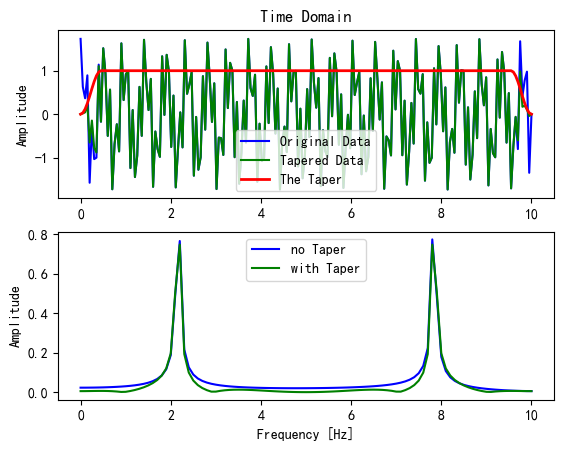

In [2]:
samp = 200                                # 采样点数量（初始值：200）
delta = 0.05                              # 采样间隔（初始值：0.05）
freq1 = 2.15                              # 产生信号的发生器频率（初始值：2.15）
freq2 = 7.8                               # 产生信号的发生器频率（初始值：7.8）
temp = np.linspace(0.0, samp*delta, samp) # 时间轴（单位：秒）

# 设置初始信号
# 生成频率为freq1赫兹的正弦波信号
# dat = np.sin(freq1 * 2.0 * np.pi * temp)
# 为正弦波的零点添加一个偏移量
dat = np.sin(freq1 * 2.0 * np.pi * temp + np.pi/3)
## 将频率为freq2赫兹的另一个正弦波添加到信号中
dat = dat + np.sin(freq2 * 2.0 * np.pi * temp + np.pi/3)
#noise_amplitude = 0.7
## 为信号添加噪声
#dat = dat + np.random.randn(len(dat)) * noise_amplitude 
# 确定数据的最大振幅（用于绘图）
maximum = max(dat)

print('Before Taper')
print('amplitude of first sample point:%6.1f' %dat[0])
print('amplitude of last sample point:%6.1f' %(dat[len(dat)-1]))

# 定义平滑窗
# 应用的锥度百分比[0. - 1.]（初始值：0.1）
taper_percentage = 0.1
# 定义锥度窗口。
taper = cosine_taper(samp,taper_percentage)
# 对信号进行锥度处理。
dat_taper = dat * taper

print('After Taper')
print('amplitude of first sample point:%6.1f' %dat_taper[0])
print('amplitude of last sample point:%6.1f' %(dat_taper[len(dat_taper)-1]))

# 将FFT数据转换为频域数据
Fdat = np.fft.rfft(dat, n=samp)
Fdat_taper = np.fft.rfft(dat_taper, n=samp)
# 用于绘图的频域x轴
xf = np.linspace(0.0, 1.0/(2.0*delta), int((samp/2)+1))

# 绘图
plt.subplot(211)
plt.title('Time Domain')
plt.plot(temp, dat, label="Original Data", color='b', linewidth=1.5)
plt.plot(temp, dat_taper, label="Tapered Data", color='g',linewidth=1.5)
plt.plot(temp, taper, label="The Taper", color='r', linewidth=2)
plt.legend(loc='lower center')
plt.ylabel('Amplitude')
plt.ylim(-(maximum+0.2),maximum+0.2)

plt.subplot(212)
plt.plot(xf, 2.0/samp * np.abs(Fdat), color='b',label="no Taper",linewidth=1.5)
plt.plot(xf, 2.0/samp * np.abs(Fdat_taper), label="with Taper", color='g',linewidth=1.5)
plt.legend()
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')

plt.show()

### 2.频谱计算
```
1) 以256个样本的初始值，我们只能看到垂直线，因此只能确定预期高幅度的时刻。我们无法说这些高幅度出现在哪些频率。当我们将样本点数增加到，比如说NFFT=32768时，情况恰恰相反。我们现在看到水平线，也就是说我们可以清楚地定义频率，但不能确定它们出现的时刻。这再次是不确定性原理。通过增加用于生成频谱图的FFT的样本数并保持信号的时间长度不变，我们减小了Δf并增加了频域中的分辨率。
2) 时间窗口越长，我们看到的第一次到达的开始时间越清晰。为了使Δf变小，即在频域中获得良好的分辨率，我们需要高周期T，即我们需要在时域中的长信号。
3) 当我们将时间窗口设置在例如3500到8500秒之间，并将样本数增加到例如2048时，我们可以看到最高幅度的频率发生了变化。我们得到了从低频到高频的曲线。这是地表波的频散，仅仅是频谱图有用的一个应用。
```

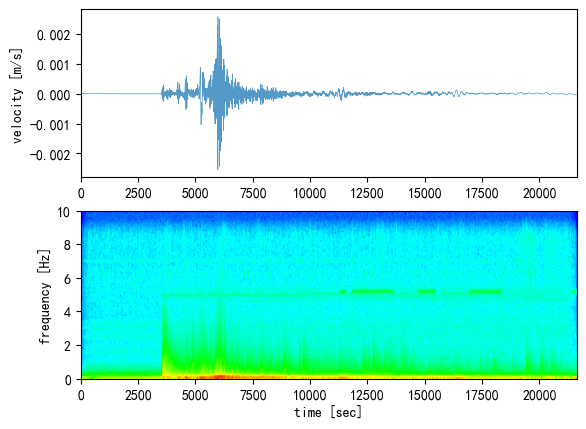

In [3]:
st = read("../data/spect_trace.mseed")
# 去仪器响应
inv = read_inventory("../data/GR.WET.xml")
st.remove_response(output="VEL", inventory=inv)
st.detrend('linear')
st.detrend('demean')

tr = st[0]
NFFT = 256     # 谱图窗长度
noverlap = 64  # 滑动窗口重叠点数量，必须小于NFFT
xstart = 0     # X轴起始点
xend = 21627   # 信号长度，单位为秒

# 绘图
ax1 = plt.subplot(211)
plt.plot(tr.times(), tr.data, linewidth=0.5, color="#5499C7")
plt.ylabel('velocity [m/s]')

plt.subplot(212, sharex=ax1)
# Pxx 瞬时功率的分段乘以频率数组
# freqs 频率向量
# bins 计算功率的时间区间的中心
# im matplotlib.image.AxesImage实例
Pxx, freqs, bins, im = plt.specgram(tr.data, NFFT=NFFT, Fs=tr.stats.sampling_rate, 
                                    noverlap=noverlap, cmap=pqlx)
# pqlx plt.cm.gist_heat
plt.ylabel('frequency [Hz]')
plt.xlabel('time [sec]')

plt.ylim(0,10)
plt.xlim(xstart, xend)
plt.show()

(0.0, 1.0)

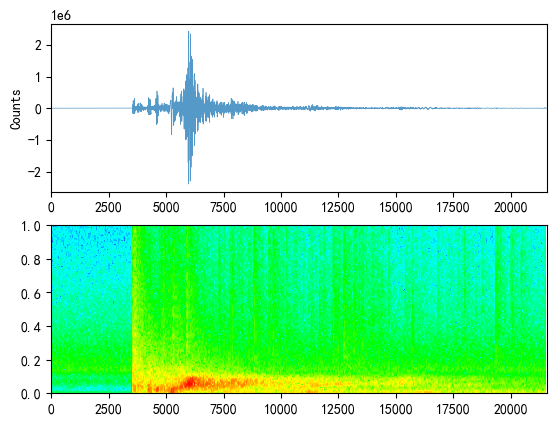

In [4]:
st = read("../data/spect_trace.mseed")
tr = st[0]

ax1 = plt.subplot(211)
plt.plot(tr.times(), tr.data, linewidth=0.5, color="#5499C7")
plt.ylabel('Counts')

ax2 = plt.subplot(212, sharex=ax1)
fig = tr.spectrogram(wlen=100, per_lap=0.5, dbscale=True, cmap=pqlx, axes=ax2, show=False)
plt.ylim(0,1.0)

(0.0, 50.0)

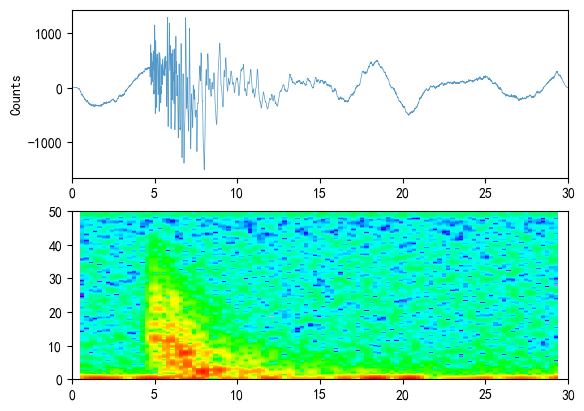

In [5]:
st = read("../data/test_trace.mseed")
tr = st[0]

ax1 = plt.subplot(211)
plt.plot(tr.times(), tr.data, linewidth=0.5, color="#5499C7")
plt.ylabel('Counts')

ax2 = plt.subplot(212, sharex=ax1)
fig = tr.spectrogram(per_lap=0.8, wlen=1, dbscale=True, axes=ax2, mult=10.0, cmap=pqlx)
plt.ylim(0,50)

### 2.数据滤波